In [30]:
import pandas as pd
import joblib
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load_config(config_file="../config.json"):
    """Load configuration from a JSON file."""
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

In [14]:
test_df = pd.read_csv('../outputs/test_df.csv')

In [15]:
test_df.columns

Index(['projectid', 'teacher_referred_count',
       'total_price_excluding_optional_support', 'students_reached',
       'fully_funded', 'date_posted', 'total_projects_in_city',
       'total_projects_in_state', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_su

In [16]:
test_df = pd.read_csv('../outputs/test_df.csv')
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])

In [17]:
# Set max_date to filter projects posted for at least 3 months
fixed_max_date = pd.to_datetime('2013-12-31')
test_df['months_since_posted'] = ((fixed_max_date - test_df['date_posted']) / pd.Timedelta(days=30)).astype(int)
eligible_projects = test_df[test_df['months_since_posted'] >= 3].copy()

In [26]:
test_df

,projectid,teacher_referred_count,total_price_excluding_optional_support,students_reached,fully_funded,date_posted,total_projects_in_city,total_projects_in_state,poverty_level_high poverty,poverty_level_highest poverty,...,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,months_since_posted
0,a11d5c86692ef20e9f702094504bb5db,0.0,387.13,34.0,1.0,2013-01-01,290,126242,False,False,...,False,False,False,False,False,True,False,False,False,12
1,8bdc6b4cfc850f6f7cc3963c48ba454b,0.0,1045.00,120.0,0.0,2013-01-01,172,2127,False,True,...,False,False,False,False,False,False,False,False,True,12
2,88f263f1cd657bccce254ffc0b79df4d,2.0,868.02,28.0,1.0,2013-01-01,102,126242,True,False,...,False,False,False,False,False,True,False,False,False,12
3,a8a6e08b6ae7ab1a88c16ba82ac8e9da,0.0,515.00,96.0,1.0,2013-01-01,206,14853,False,True,...,False,False,False,False,True,False,False,False,False,12
4,be21151602e4fd47dd4012114fd519c6,0.0,238.56,25.0,1.0,2013-01-01,337,18615,False,True,...,False,False,False,False,False,True,False,False,False,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114032,a0e839f24645e3d6dcbd327f8441b043,0.0,567.18,60.0,1.0,2013-12-31,20364,73182,False,True,...,False,False,True,False,False,True,False,False,False,0
114033,f820ef3537f4445b0716244fae36f763,0.0,277.37,30.0,0.0,2013-12-31,55,2030,True,False,...,False,False,False,True,False,False,False,False,False,0
114034,95ee208a51831edffa7cc2e0aa3e83cd,0.0,202.34,98.0,1.0,2013-12-31,2945,9837,False,True,...,False,False,False,True,False,False,False,False,False,0
114035,1aa5e1d739a40c2763da1a0bb0f0f335,2.0,177.18,23.0,1.0,2013-12-31,855,17299,False,True,...,False,False,False,False,False,False,True,False,False,0


In [24]:
config = load_config()
poverty_levels = ["low", "moderate", "high", "highest"]
recommendations = {}

In [27]:
for pov_level in poverty_levels:
    pov_column = f"poverty_level_{pov_level} poverty"
    pov_projects = eligible_projects[eligible_projects[pov_column] == 1].copy()
    classifier = joblib.load(f"../outputs/random_forest_{pov_level}_poverty.pkl")
    X_test_filtered = pov_projects.drop(columns=['fully_funded', 'date_posted', 'months_since_posted', 'projectid'], errors='ignore')
    X_test_filtered = X_test_filtered.reindex(columns=classifier.feature_names_in_, fill_value=0)
    pov_projects['probability_fully_funded'] = classifier.predict_proba(X_test_filtered)[:, 1]
    pov_projects_sorted = pov_projects.sort_values(by='probability_fully_funded', ascending=False)
    
    if pov_level in ["high", "highest"]:
        top_recommendations = pov_projects_sorted.head(10)
    elif pov_level in ["low", "moderate"]:
        top_recommendations = pov_projects_sorted.head(3)
    
    recommendations[pov_level] = top_recommendations[['projectid', 'date_posted', 'probability_fully_funded']]

In [28]:
for pov_level, recs in recommendations.items():
    print(f"\nTop recommendations for poverty level '{pov_level}':")
    print(recs)


Top recommendations for poverty level 'low':
                              projectid date_posted  probability_fully_funded
72437  f4064b13c27c1fbdc31b151719ba9f08  2013-09-25                       1.0
14699  4d2509f0f54df77ab927609b49749094  2013-03-01                       1.0
24210  71de20531b97210cbe5f1fa8d9c6c148  2013-04-19                       1.0

Top recommendations for poverty level 'moderate':
                              projectid date_posted  probability_fully_funded
54870  b736a74ca2c9b8a6cc8d1d9ee1e4c2b2  2013-08-25                       1.0
68404  8e4065284366cb9f7911e4f72de60add  2013-09-17                       1.0
33098  7cec345ecf8bbf5457449a501ee97b88  2013-06-08                       1.0

Top recommendations for poverty level 'high':
                              projectid date_posted  probability_fully_funded
16897  f5c1c43b25747deee09bdc0df6852e15  2013-03-09                       1.0
4744   fc00aeeb883f2e406d20a3d318311204  2013-01-22                       1.

In [31]:
top_n_per_poverty_level = {"high": 10, "highest": 10, "low": 3, "moderate": 3}

/var/folders/5m/4tj5fx915fv1z073c22c2q7m0000gn/T/ipykernel_9485/3164605984.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5m/4tj5fx915fv1z073c22c2q7m0000gn/T/ipykernel_9485/3164605984.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5m/4tj5fx915fv1z073c22c2q7m0000gn/T/ipykernel_9485/3164605984.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/5m/4tj5fx915fv1z073c22c2q7m0000gn/T/ipykernel_9485/3164605984.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

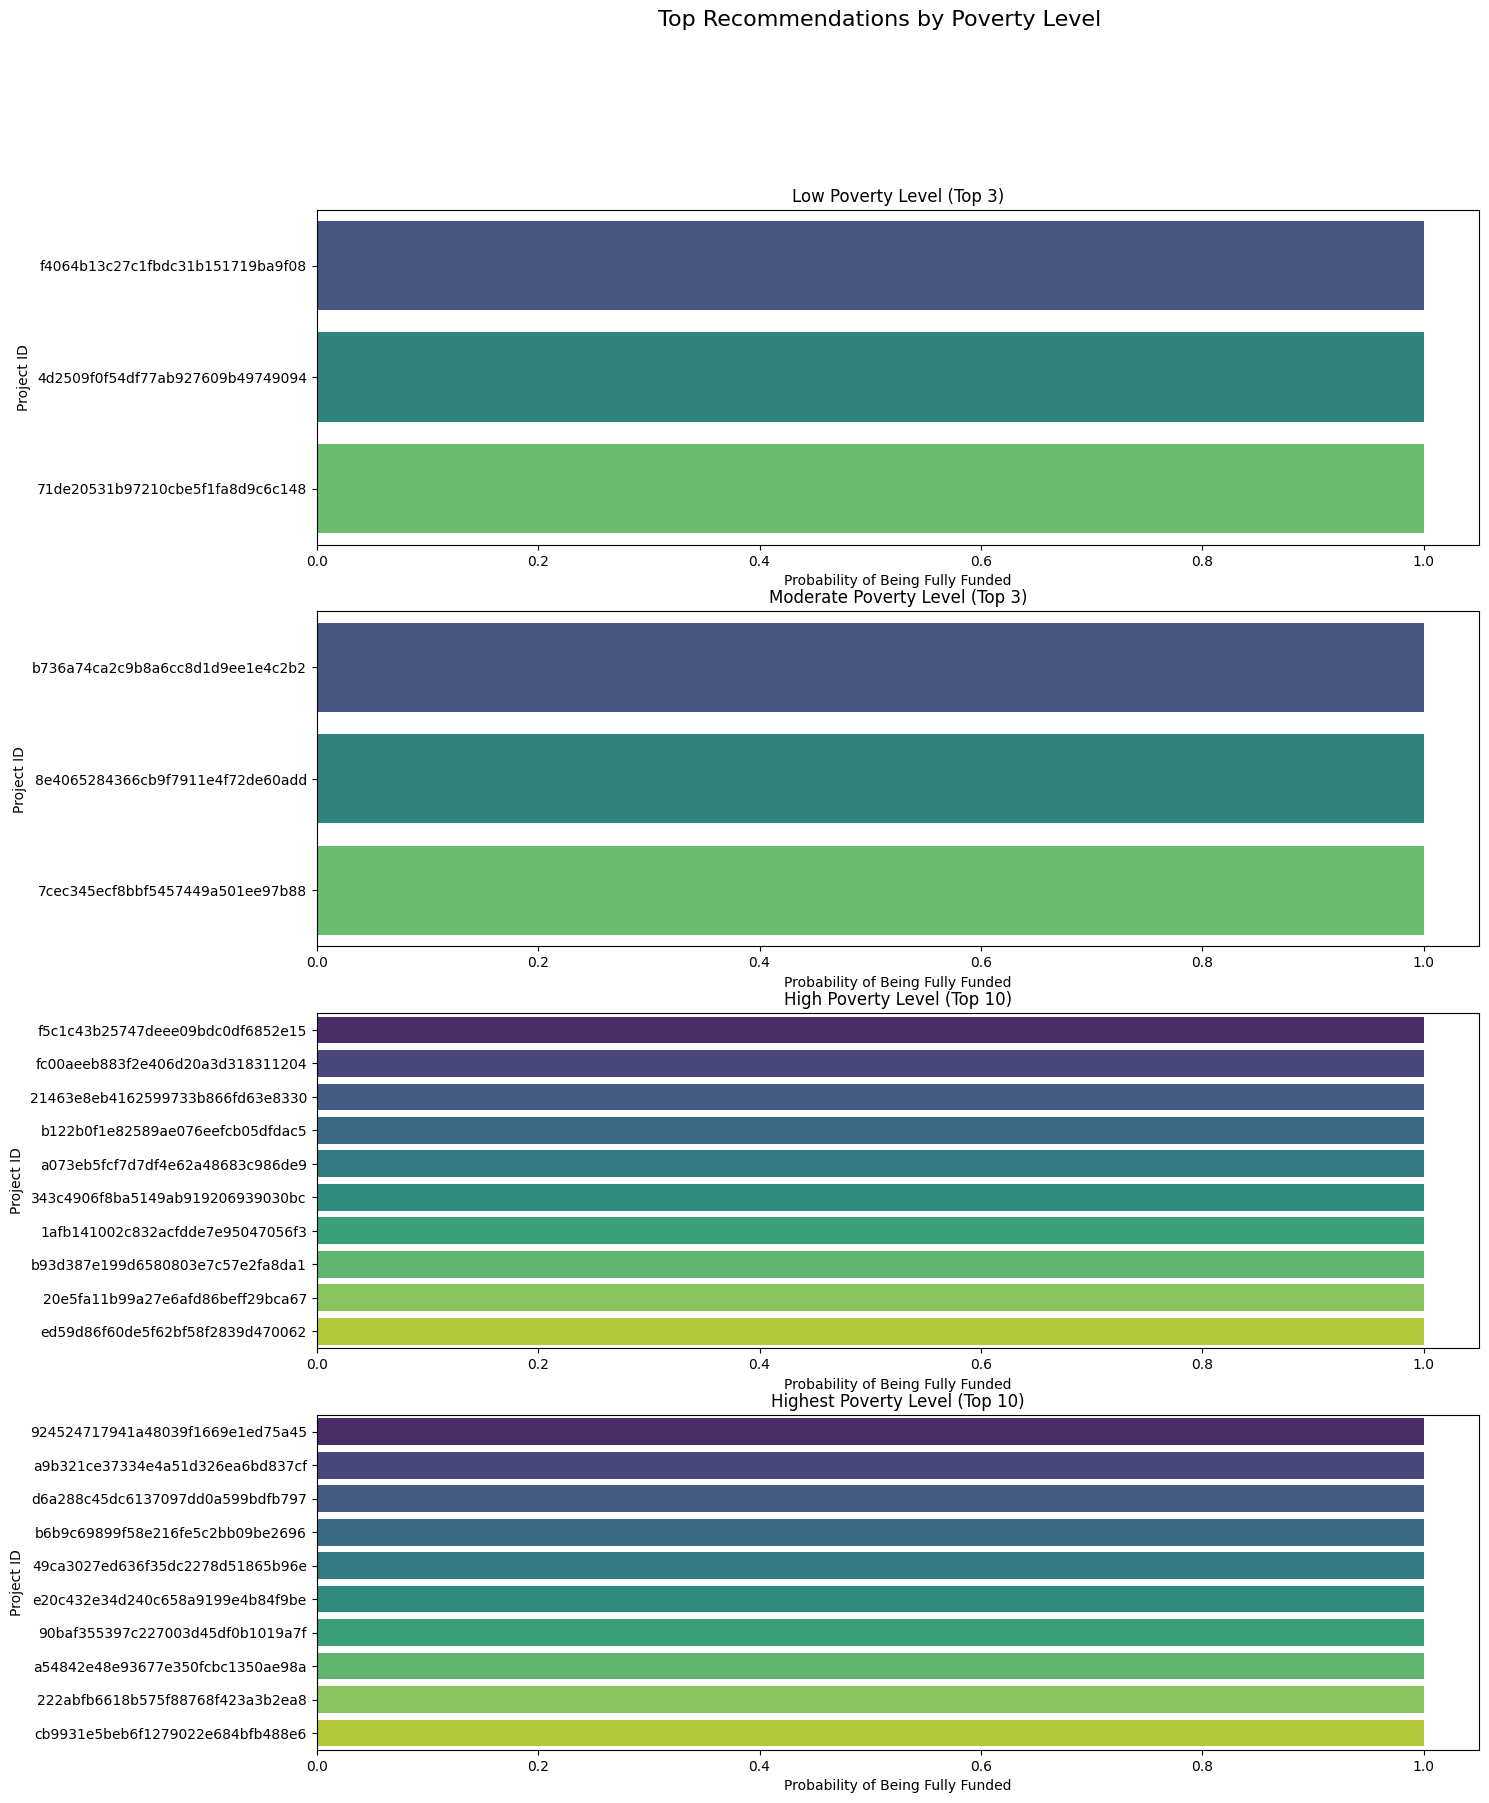

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle("Top Recommendations by Poverty Level", fontsize=16)

ax = ax.flatten()

for i, (pov_level, recs) in enumerate(recommendations.items()):
    # Limit the number of projects to the specified top N for this poverty level
    top_recs = recs.head(top_n_per_poverty_level[pov_level])
    
    # Create a barplot in the respective subplot axis
    sns.barplot(
        x='probability_fully_funded', 
        y='projectid', 
        data=top_recs, 
        palette="viridis", 
        ax=ax[i]
    )
    
    # Set labels and title for each subplot
    ax[i].set_title(f"{pov_level.capitalize()} Poverty Level (Top {top_n_per_poverty_level[pov_level]})")
    ax[i].set_xlabel('Probability of Being Fully Funded')
    ax[i].set_ylabel('Project ID')
    
fig.savefig("../outputs/top_recommendations_by_poverty_level.png", dpi=300)